In [1]:
from DRT.generation import *
from DRT.tree_structure import *
from DRT.sampler_DRT import *
import matplotlib.pyplot as plt

One can define any tree stucture simply as follows, based on the **tree_structure.py** file.

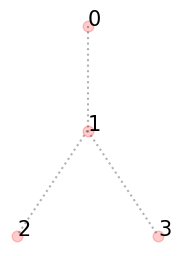

In [2]:
tree = Tree({0: [1], 1: [2,3]}) # Tree in tree_structure implements the functioning of this tree

fig, ax = plt.subplots(figsize=(2,3))
tree.plot(ax)
plt.show()

To generate synthetic data, use the helper functions in **generation.py**

In [3]:
V = 30 # vocabulary size
I, J, K = tree.size # collect size
m = 200 # number of documents
n = 100 # number of words per document

topics = generate_topics(K, V, 1.0, seed=20) # generate random topics, 20 is seed
pi = np.ones(I) / I
alpha0 = 0.9
alpha = np.ones(J) * alpha0


X, C, L = treelda_data(m, n, topics, alpha, pi, tree, seed=10) # X has shape (m,n)
Y_count = convert_doc_word_count(np.array(X), V) # Y_count has shape (m,V)
Y = Y_count / Y_count.sum(axis=1)[:,None] # normalized word frequency per document (m,V)


To visualize the geometry of the model, use the plot function

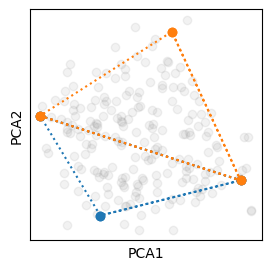

In [4]:
fig, ax = plt.subplots(figsize=(3,3))
# use the plot function in generation to show the latent structure along with documents
plot(ax, Y, V, tree, C=None, topics_true=topics, topics_est=None, title=None, scatter_alpha=0.1, pca_dim1=1, pca_dim2=2, legend=False)
ax.set_xticks([])
ax.set_yticks([])
plt.show()

To fit the model via Gibbs sampler: use *Gibbs_TreeLDA* from **sampler_DRT.py** - single chain with random initialization (or you can pass initialization for the path labels $C$ and/or level labels $L$.

Documents: 200, vocabulary size: 30, total words = 20000


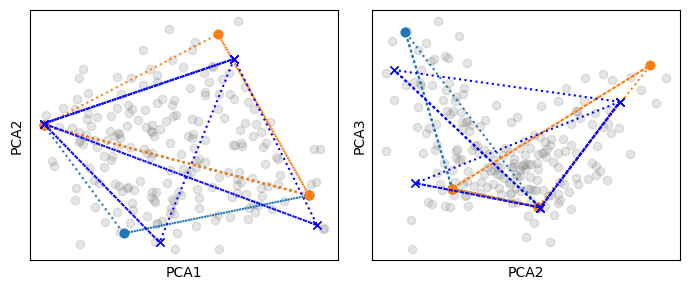

In [5]:
key = jax.random.PRNGKey(10)
corpus = convert_list(X, V, verbose=True) # use this before fit (converts data to a list (doc_id, word_id))
paths = jnp.array(tree.paths()) # get paths in tree -> use this in the Gibbs sampler

# one sampler initialized randomly
Theta_samples, Pi_samples, logliks = Gibbs_TreeLDA(key, 
                                                   corpus, 
                                                   K, 
                                                   V, 
                                                   paths, 
                                                   alpha, 
                                                   eta=1.0, 
                                                   pi0=1.0, 
                                                   iterations=3000, 
                                                   n_samples=500, 
                                                   C_init=None, 
                                                   L_init=None)
# alternatively: use fit in simulation_utils, 

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(7,3))
plot(ax1, Y, V, tree, C=None, topics_true=topics, topics_est=Theta_samples[-1], title=None, scatter_alpha=0.2, pca_dim1=1, pca_dim2=2, legend=False)
plot(ax2, Y, V, tree, C=None, topics_true=topics, topics_est=Theta_samples[-1], title=None, scatter_alpha=0.2, pca_dim1=2, pca_dim2=3, legend=False)
ax1.set_xticks([])
ax1.set_yticks([])
ax2.set_xticks([])
ax2.set_yticks([])
plt.tight_layout()
plt.show()

In this case, although the four topics were (kind of) estimated pretty close, their sharing structure was estimated incorrectly. This can be rectified by more clever initialization and/or with multiple chains - for this, use the *fit* function from **simulation_utils.py**

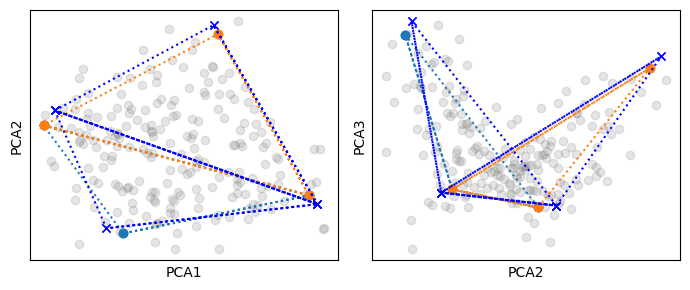

Time taken per chain Macbook i7 CPU: 46.36 sec
Note this example had m=200, n=100, V=30
Time taken per doc per iteration: 0.000066 sec


In [9]:
# use fit function: 8 chains initialized through LDA
from DRT.simulation_utils import fit
key = jax.random.PRNGKey(10)
Theta_samples2, Pi_samples2, nll2, time_taken = fit(key, 
                                                 corpus, 
                                                 V, 
                                                 alpha0, 
                                                 tree, 
                                                 n_jobs=4, 
                                                 iterations=3000, 
                                                 n_samples=500)

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(7,3))
plot(ax1, Y, V, tree, C=None, topics_true=topics, topics_est=Theta_samples2[-1], title=None, scatter_alpha=0.2, pca_dim1=1, pca_dim2=2, legend=False)
plot(ax2, Y, V, tree, C=None, topics_true=topics, topics_est=Theta_samples2[-1], title=None, scatter_alpha=0.2, pca_dim1=2, pca_dim2=3, legend=False)
ax1.set_xticks([])
ax1.set_yticks([])
ax2.set_xticks([])
ax2.set_yticks([])
plt.tight_layout()
plt.show()

print(f'Time taken per chain Macbook i7 CPU: {time_taken:.2f} sec')
print(f'Note this example had m=200, n=100, V=30')
print(f'Time taken per doc per iteration: {time_taken/(3500*200):.6f} sec')

Much better! We can check the various distance measures for this fit from the **metrics.py** file. Note that the *correct_structure* finding code is limited to the two tree structures used in the simulation.

In [11]:
from DRT.metrics import *
paths = jnp.array(cpaths(tree), dtype=jnp.int32)

# for the single fit
distances = parallel_metrics2(topics, Theta_samples, pi, Pi_samples, paths).mean(axis=0)
correct = correct_structure_tree1(topics, Theta_samples[-1], tree)
err_W1 = distances[0]
err_L2 = distances[1]
print("*** Results for single chain random initialization ***")
print(f'd_L2 = {err_L2}')
print(f'd_W1 = {err_W1}')
print(f'correct tree structure = {correct}')


# for the multiple fit
distances = parallel_metrics2(topics, Theta_samples2, pi, Pi_samples2, paths).mean(axis=0)
correct = correct_structure_tree1(topics, Theta_samples2[-1], tree)
err_W1 = distances[0]
err_L2 = distances[1]
print("*** Results for fit function - multiple chains LDA-based initialization ***")
print(f'd_L2 = {err_L2}')
print(f'd_W1 = {err_W1}')
print(f'correct tree structure = {correct}')

*** Results for single chain random initialization ***
d_L2 = 0.004551007631343426
d_W1 = 0.0022950337222982734
correct tree structure = 0
*** Results for fit function - multiple chains LDA-based initialization ***
d_L2 = 0.002154750962727957
d_W1 = 0.0011264645973915325
correct tree structure = 1


## New York Times Example

Let us look at the NYT subset data now - for the preprocessing of the raw text, see the notebook under the *NYT* folder.

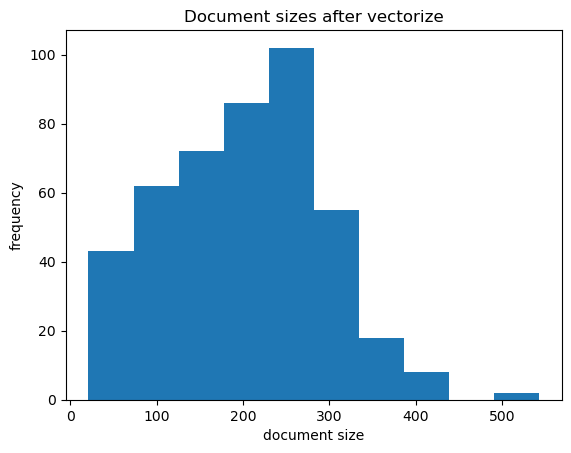

Documents: 448, vocabulary size: 500, total words = 90667


In [15]:
import pickle
import pandas 

with open('NYT/nyt_data.pkl', 'rb') as f:
    data = pickle.load(f)
    
vocab = data['vocab']
Y_train, Y_test, category_train, category_test = data['Y_train'], data['Y_test'], data['category_train'], data['category_test']
Y, category = data['Y'], data['category']
corpus = data['corpus']
m = data['m']
n = data['n']

plt.hist(n, bins=10)
plt.title('Document sizes after vectorize')
plt.xlabel('document size')
plt.ylabel('frequency')
plt.show()

V = Y.shape[1]
print(f'Documents: {m}, vocabulary size: {V}, total words = {len(corpus)}')

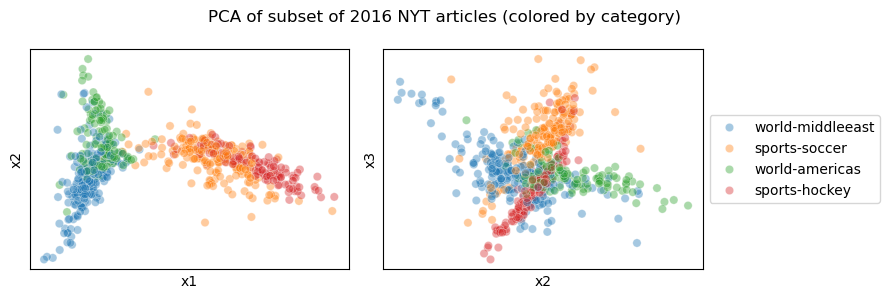

In [16]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

Y_prop = Y / Y.sum(axis=1)[:,None]
Y_pca = PCA(n_components=4).fit_transform(Y_prop)

PCA_df = pd.DataFrame({'x1': Y_pca[:,0], 
                       'x2': Y_pca[:,1], 
                       'x3': Y_pca[:,2],
                       'x4': Y_pca[:,3],
                       'section': category})

fig = plt.figure(figsize=(9, 3))

plt.subplot(1,2,1)
sns.scatterplot(data=PCA_df, x='x1', y='x2', hue='section', alpha=0.4)
plt.legend([],[], frameon=False)
plt.xticks([])
plt.yticks([])

plt.subplot(1,2,2)
sns.scatterplot(data=PCA_df, x='x2', y='x3', hue='section', alpha=0.4)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xticks([])
plt.yticks([])

plt.suptitle('PCA of subset of 2016 NYT articles (colored by category)')
plt.tight_layout()
#plt.savefig('Plots/nyt_pca2.pdf')
plt.show()

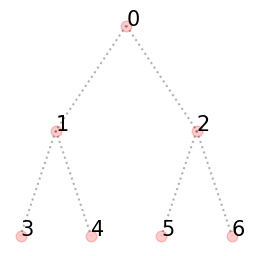

In [17]:
# set up the tree structure
tree = Tree({0: [1,2], 1: [3,4], 2:[5,6]})
fig, ax = plt.subplots(figsize=(3,3))
tree.plot(ax)
plt.show()

In [19]:
# fit with alpha=1.0
import time

key = jax.random.PRNGKey(10)
alpha = 1.0
time_start = time.time()
Theta_samples, Pi_samples, nll, time_taken = fit(key, corpus, V, alpha, tree, n_jobs=4, eta=0.01, iterations=5000, n_samples=200)
time_end = time.time()
print(f'Time taken () = {time_taken/60 :.2f} minutes')

Time taken () = 31.16 minutes


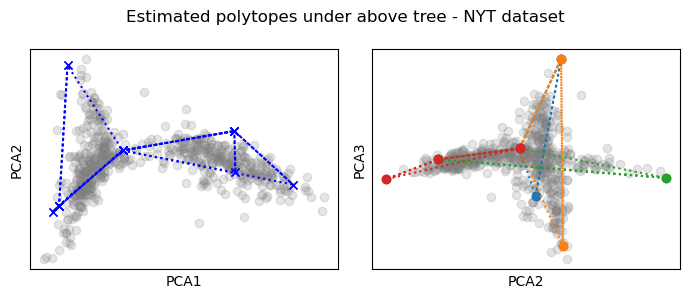

In [20]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(7,3))
plot(ax1, Y_prop, V, tree, C=None, topics_true=None, topics_est=Theta_samples[-1], title=None, scatter_alpha=0.2, pca_dim1=1, pca_dim2=2, legend=False)
ax1.set_xticks([])
ax1.set_yticks([])

plot(ax2, Y_prop, V, tree, C=None, topics_true=Theta_samples[-1], topics_est=None, title=None, scatter_alpha=0.2, pca_dim1=2, pca_dim2=3, legend=False)
plt.xticks([])
plt.yticks([])

plt.suptitle('Estimated polytopes under above tree - NYT dataset')
plt.tight_layout()
plt.show()

In [21]:
theta_hat = Theta_samples[-1]
vect = data['vocab']
def print_topic(topic_id, theta_hat, n_words=10):
    a = theta_hat[topic_id]
    ind = np.argpartition(a, -n_words)[-n_words:]
    print(f'------ TOPIC {topic_id} ------')
    for i in ind:
        print(list(vect.keys())[list(vect.values()).index(i)])
    
for k in range(theta_hat.shape[0]):
    print_topic(k, theta_hat)

------ TOPIC 0 ------
work
where
any
week
because
people
city
day
many
new
------ TOPIC 1 ------
you
him
season
play
club
game
player
league
coach
team
------ TOPIC 2 ------
egypt
plane
saudi
official
government
iran
country
american
united
egyptian
------ TOPIC 3 ------
match
minute
fan
world
soccer
united
team
tournament
goal
game
------ TOPIC 4 ------
jose
san
playoff
pittsburgh
score
second
goal
game
penguin
shark
------ TOPIC 5 ------
leader
political
woman
rousseff
president
country
brazil
she
her
party
------ TOPIC 6 ------
military
israel
force
united
palestinian
group
government
islamic
israeli
syria
